In [2]:
%pip install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import numpy as np


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\admin2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
index_kurento_names = [
    "loadtest-webrtc-final-kurento-2p-t3medium",
    "loadtest-webrtc-final-kurento-2p-t3medium-2",
    "loadtest-webrtc-final-kurento-2p-t3medium-wait",
    "loadtest-webrtc-final-kurento-2p-t3medium-retry",
    "loadtest-webrtc-final-kurento-5p-t3medium",
    "loadtest-webrtc-final-kurento-5p-t3medium-2",
    "loadtest-webrtc-final-kurento-5p-t3medium-wait",
    "loadtest-webrtc-final-kurento-5p-t3medium-retry",
    "loadtest-webrtc-final-kurento-8p-t3medium",
    "loadtest-webrtc-final-kurento-8p-t3medium-2",
    "loadtest-webrtc-final-kurento-8p-t3medium-wait",
    "loadtest-webrtc-final-kurento-8p-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-retry",
]

index_mediasoup_names = [
    "loadtest-webrtc-final-mediasoup-2p-t3medium",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-5p-t3medium",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-8p-t3medium",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-retry",
]

index_list_names = index_kurento_names + index_mediasoup_names

node_types = ["browseremulator", "masternode", "medianode"]
packet_types = ["inbound", "outbound"]

seconds_per_fragment = 17

start_end_times = pd.read_json("dfs_final/start-end-times.json", orient="index")
start_end_times["from"] = pd.to_datetime(start_end_times["from"], format="ISO8601").dt.tz_convert("UTC")
start_end_times["to"] = pd.to_datetime(start_end_times["to"], format="ISO8601").dt.tz_convert("UTC")

def timestamp_to_secs(df_node, index):
    df_tmp = df_node.copy()
    df_tmp["@timestamp"] = pd.to_datetime(df_tmp["@timestamp"], format="ISO8601")
    tmp_serie = pd.Series([df_tmp["@timestamp"].max(), start_end_times.loc[index, "to"]])
    end_time = tmp_serie.min()
    df_tmp = df_tmp[df_tmp["@timestamp"] < end_time]
    tmp_serie = pd.Series([df_tmp["@timestamp"].min(), start_end_times.loc[index, "from"]])
    start_time = tmp_serie.max()
    df_tmp['timestamp_secs'] = (df_tmp['@timestamp'] - start_time).dt.total_seconds()
    return df_tmp

In [4]:
df_list = [pd.read_csv(f"dfs_final/{x}.csv") if os.path.isfile(f"dfs_final/{x}.csv") else pd.DataFrame() for x in index_list_names ]
for df_user in df_list:
    if not df_user.empty:
        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"], format="ISO8601")
        df_user["cut_index"] = df_user["cut_index"] * seconds_per_fragment
index_data = []
data_types = node_types + packet_types
for i, df_user in enumerate(df_list):
    index = index_list_names[i]
    splitted = index.split("-")
    publishers = int(splitted[4][:-1])
    subscribers = 0
    subscribers_parsed = splitted[5]
    if subscribers_parsed[-1] == "s":
        subscribers = int(subscribers_parsed[:-1])
    users = publishers + subscribers
    repeat = 1
    type = splitted[-1]
    if type not in data_types:
        if type == "t3medium":
            repeat = "1"
        else:
            repeat = type
        index_data.append({"type": repeat, "publishers": publishers, "subscribers": subscribers, "users": users})

In [5]:
data = []
for i, df_tmp in enumerate(df_list):
    if not df_tmp.empty:
        average = df_tmp["vmaf"].mean()
        median = df_tmp["vmaf"].median()
        min = df_tmp["vmaf"].min()
        max = df_tmp["vmaf"].max()
        std = df_tmp["vmaf"].std()
        data.append([index_list_names[i], min, max, average, median, std])

pd.DataFrame(data, columns=["index_type", "min", "max", "average", "median", "std"])      

,index_type,min,max,average,median,std
0,loadtest-webrtc-final-kurento-5p-t3medium,0.419344,0.828798,0.773972,0.795153,0.060716
1,loadtest-webrtc-final-kurento-5p-t3medium-2,0.611563,0.830730,0.782007,0.790365,0.033627
2,loadtest-webrtc-final-kurento-5p-t3medium-wait,0.419344,0.828798,0.770268,0.793771,0.065331
3,loadtest-webrtc-final-kurento-5p-t3medium-retry,0.478030,0.824912,0.784662,0.792886,0.030965
4,loadtest-webrtc-final-kurento-8p-t3medium,0.735173,0.826142,0.794747,0.799478,0.018531
5,loadtest-webrtc-final-kurento-8p-t3medium-2,0.666862,0.824986,0.785034,0.790595,0.027850
6,loadtest-webrtc-final-kurento-8p-t3medium-wait,0.608139,0.824317,0.792964,0.802629,0.028911
7,loadtest-webrtc-final-kurento-8p-t3medium-retry,0.499367,0.830977,0.776196,0.789538,0.041521
8,loadtest-webrtc-final-mediasoup-5p-t3medium,0.420043,0.830688,0.784741,0.789200,0.022035
9,loadtest-webrtc-final-mediasoup-5p-t3medium-2,0.391276,0.828745,0.750297,0.779700,0.059875


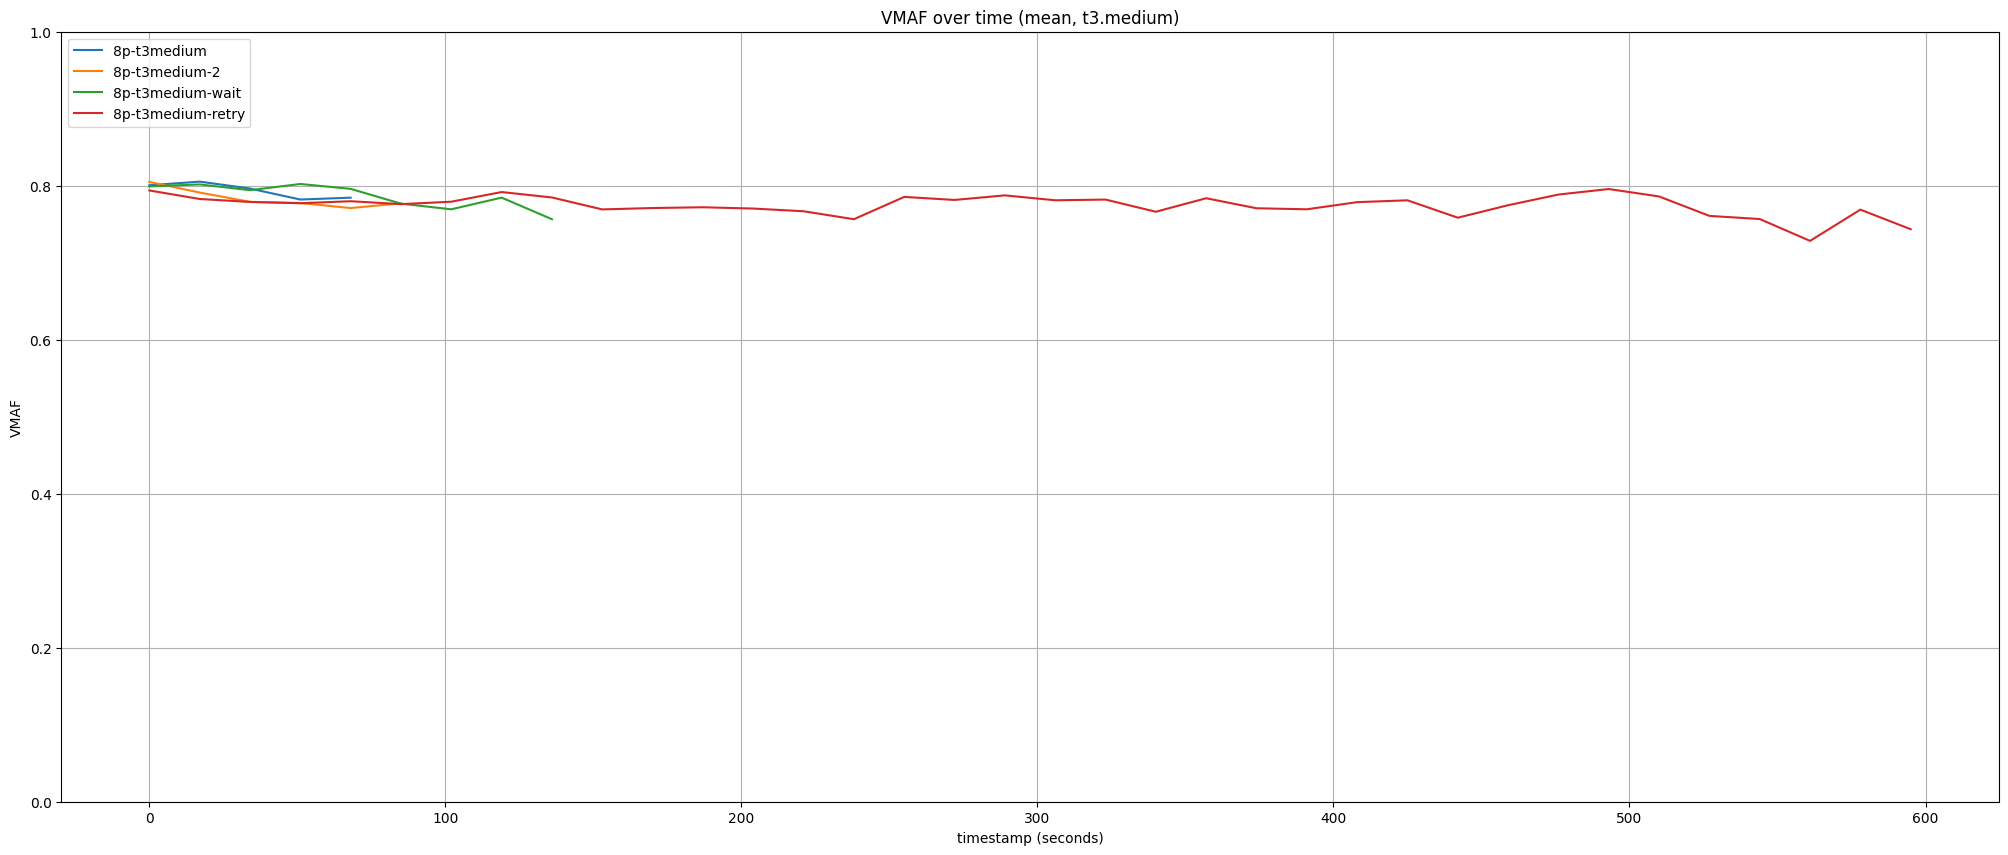

In [6]:
plt.rcParams['figure.figsize'] = [25, 10]
typology = "8p"
media_node = "kurento"

for i, df_tmp in enumerate(df_list):
    if not df_tmp.empty:
        if typology in index_list_names[i] and media_node in index_list_names[i]:
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
            plot_name = index_list_names[i][30:]
            if not df_mean.empty:
                plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, t3.medium)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")

In [7]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 8
#If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list_names[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]

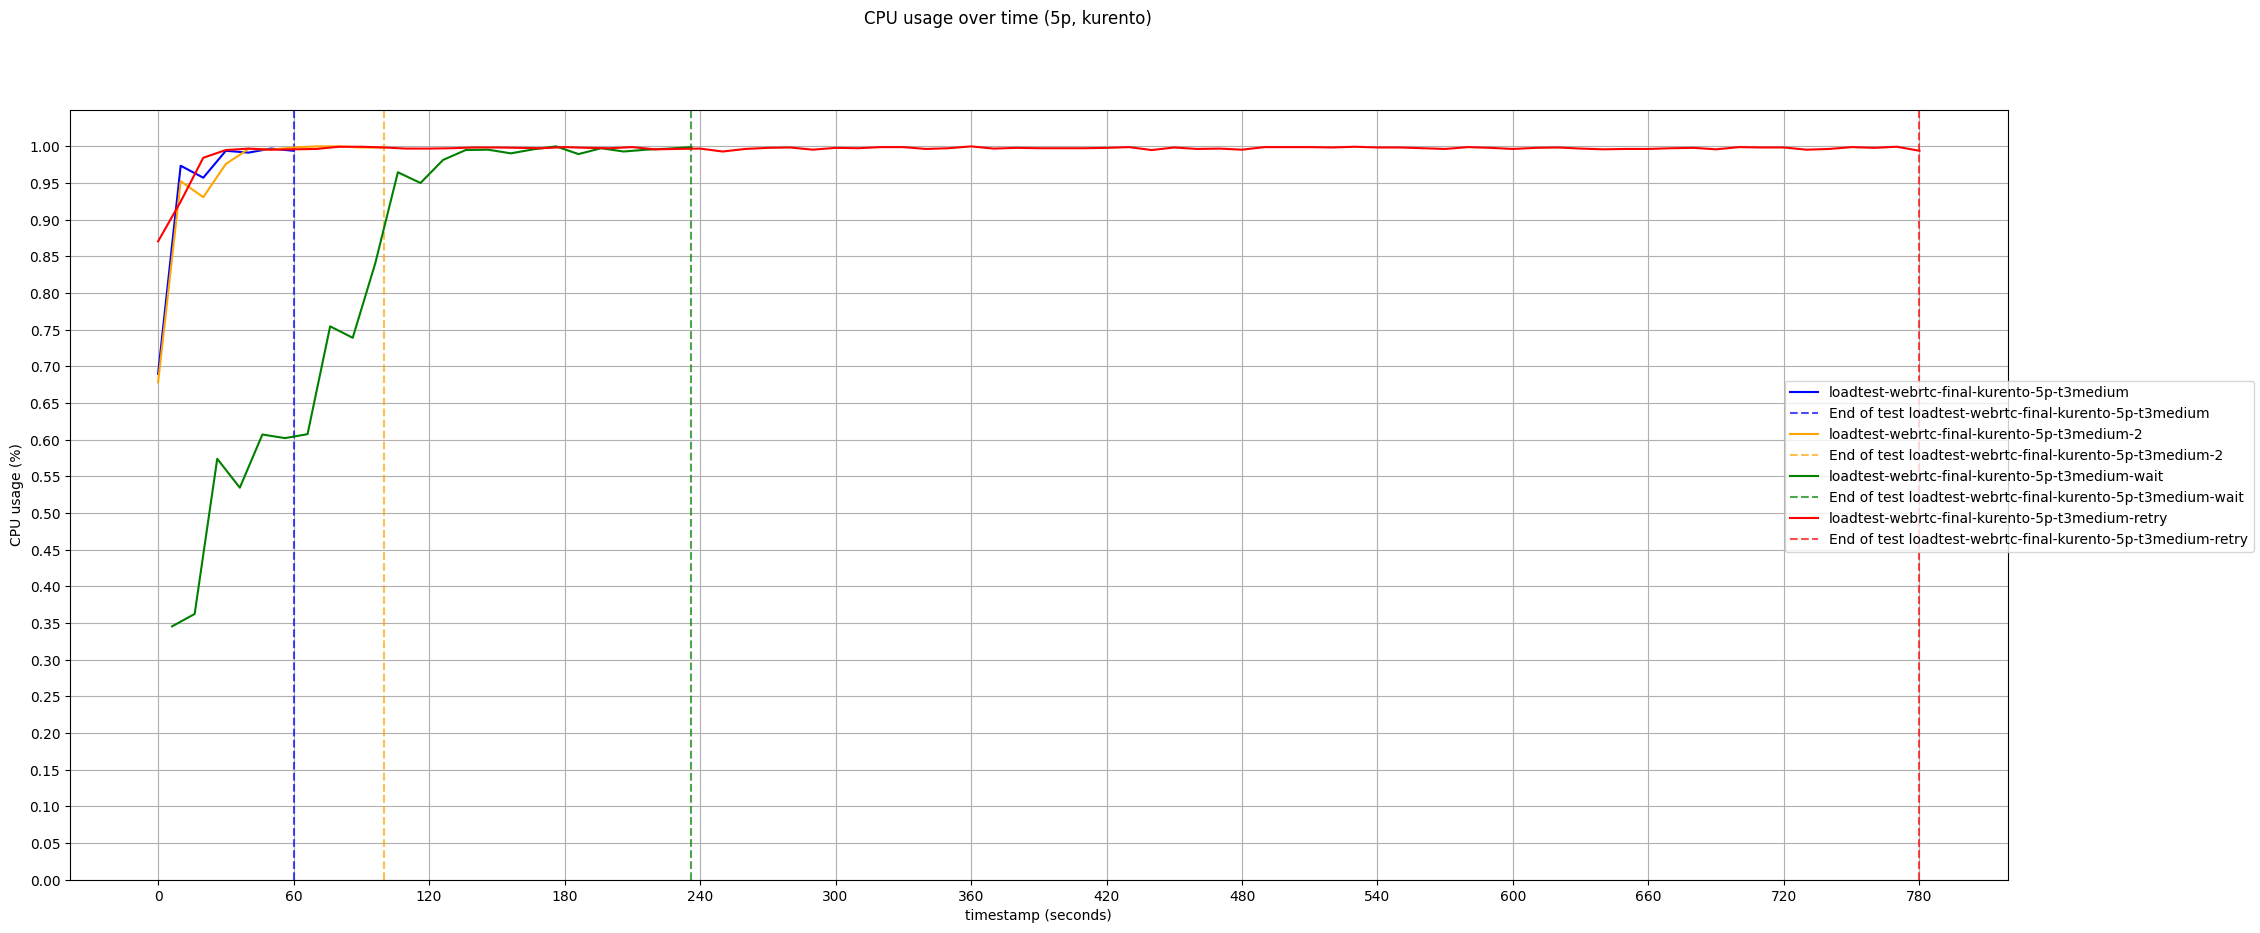

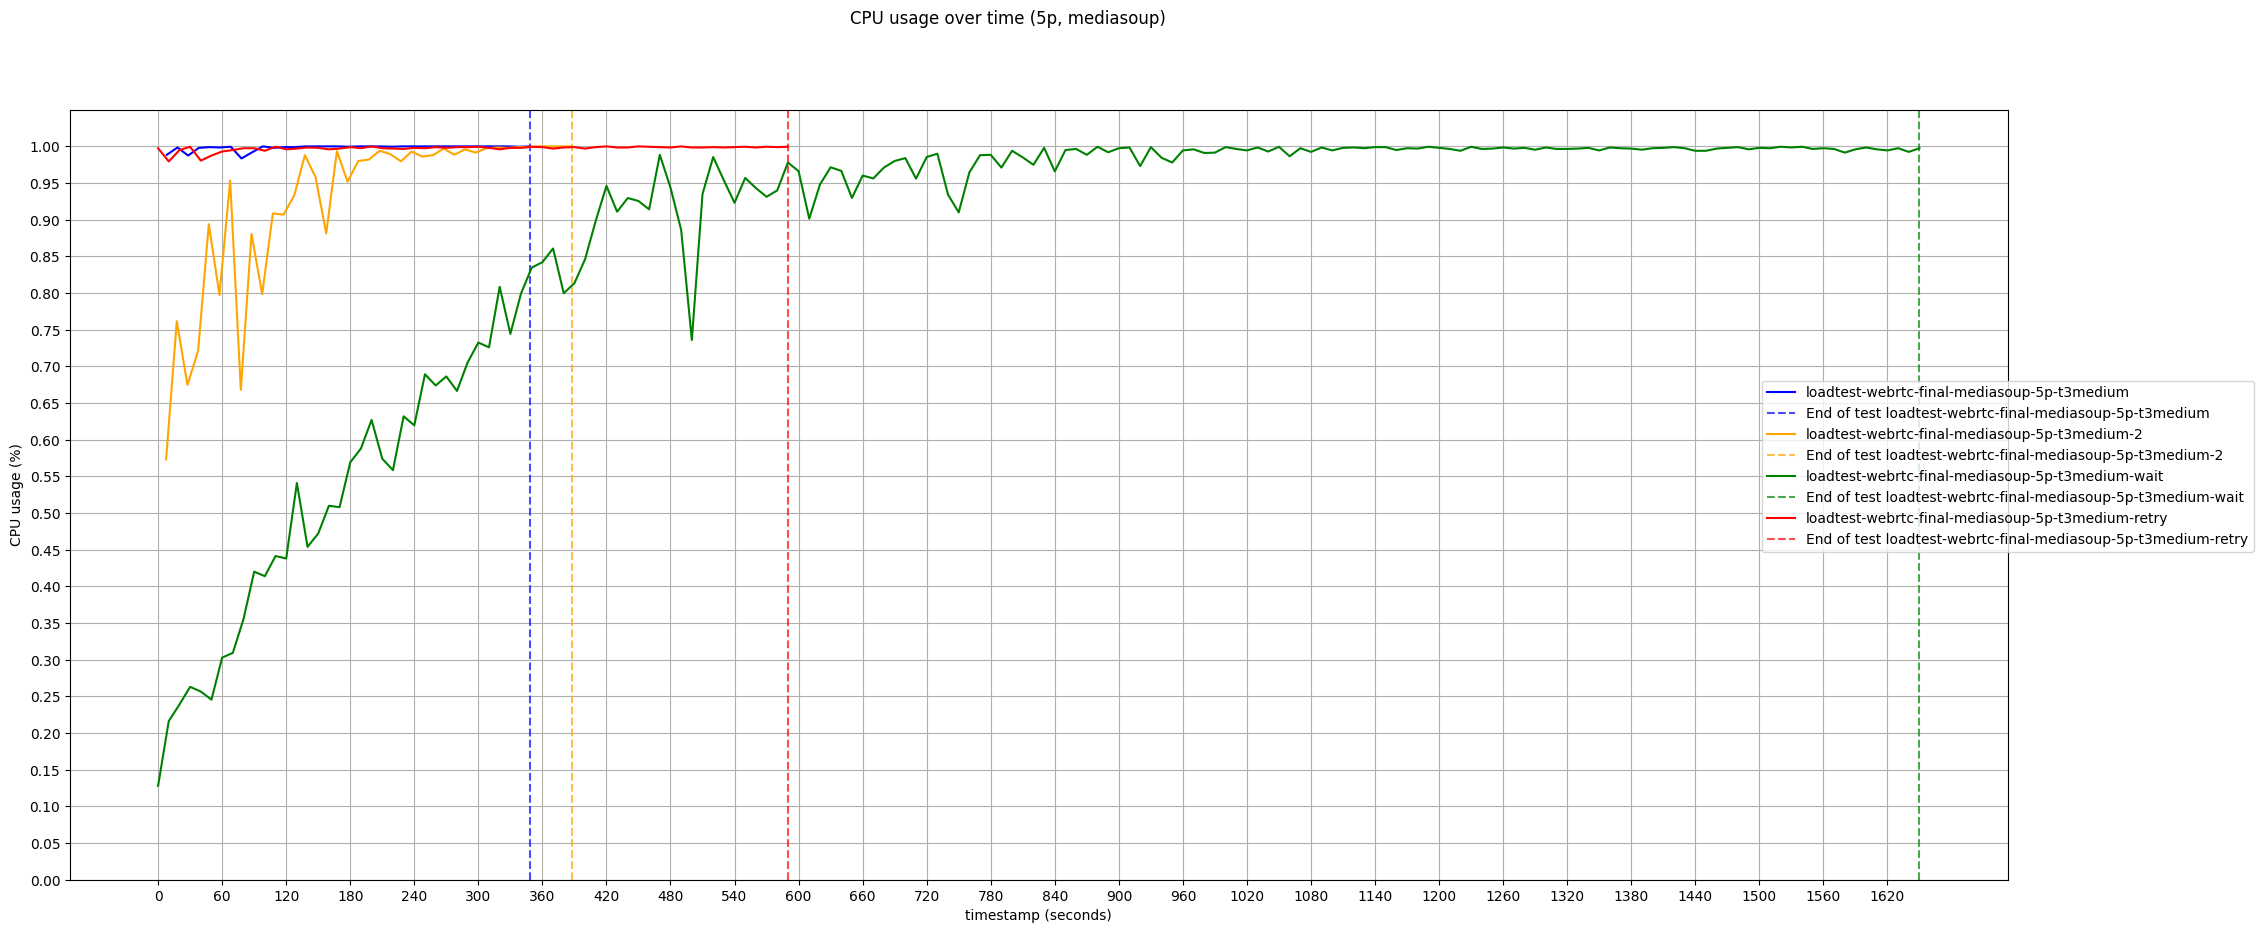

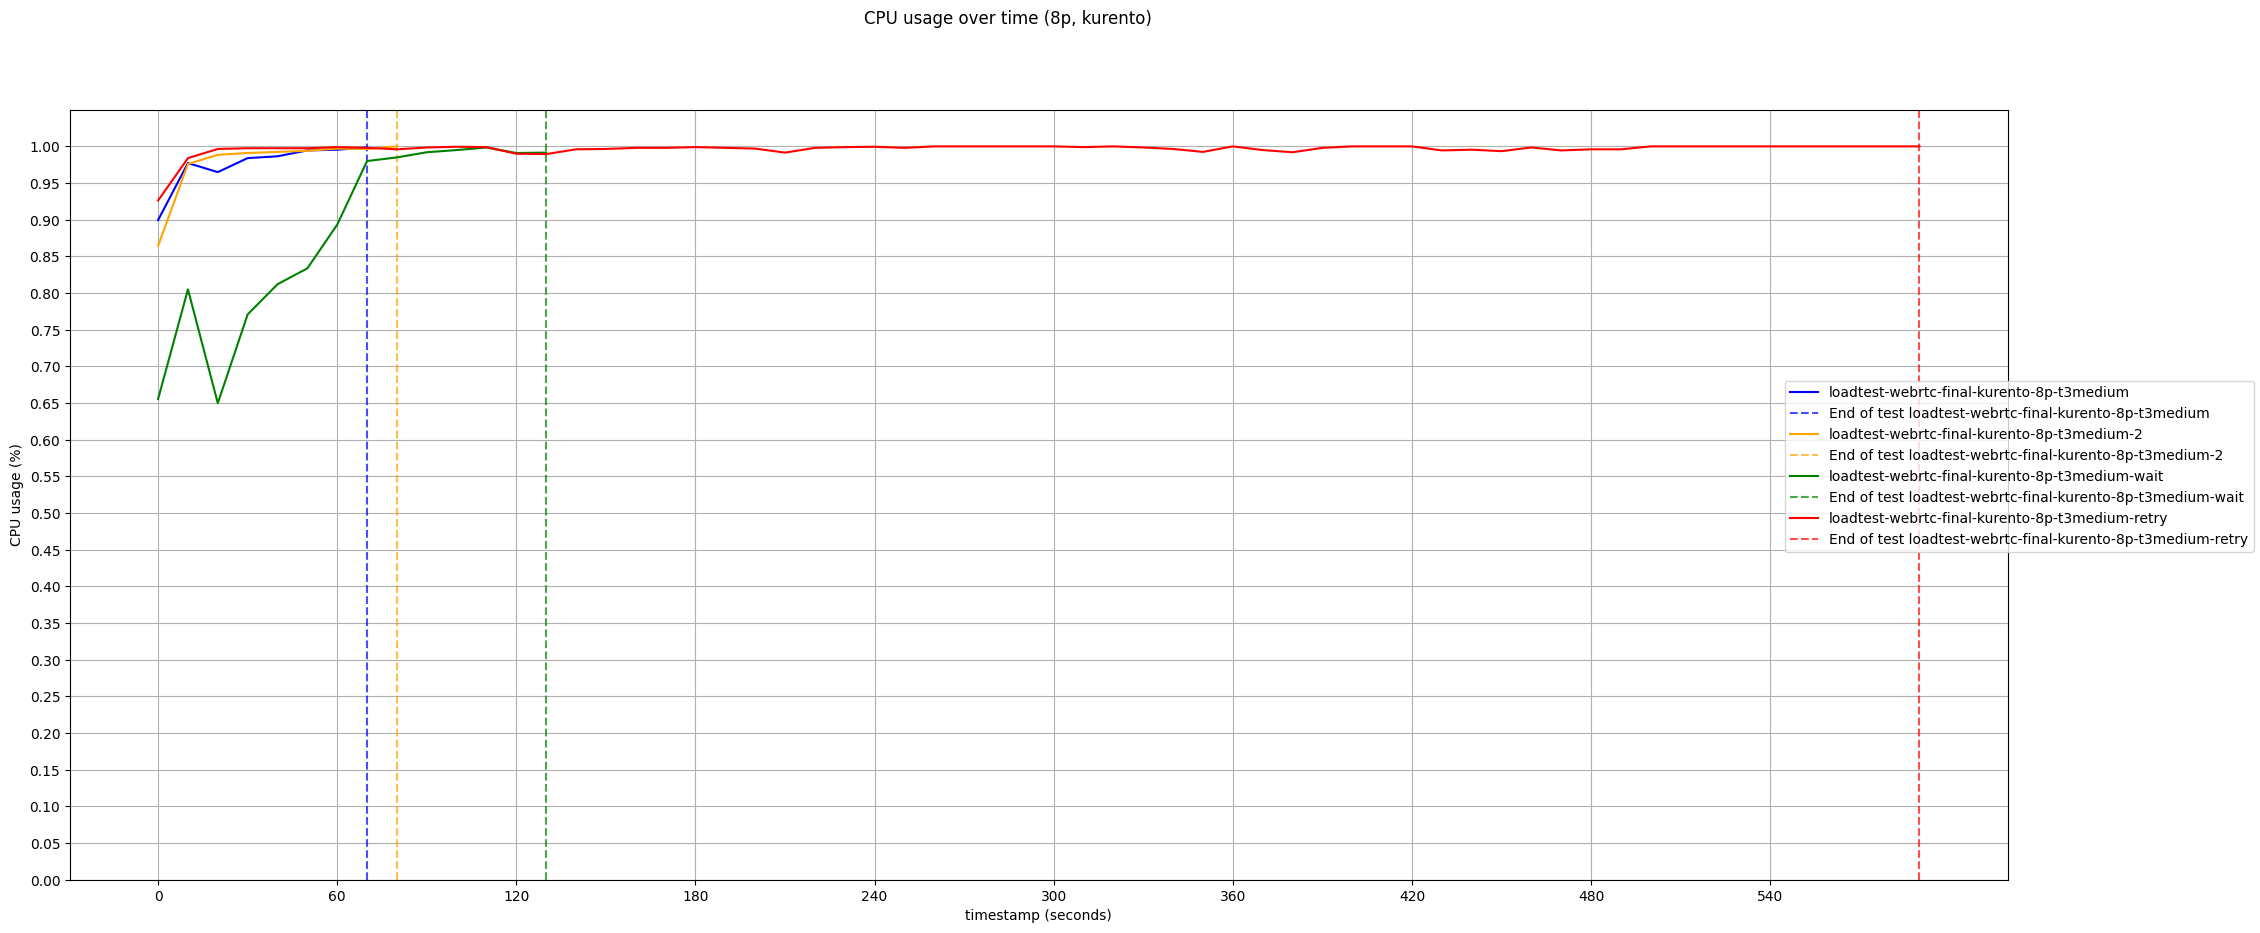

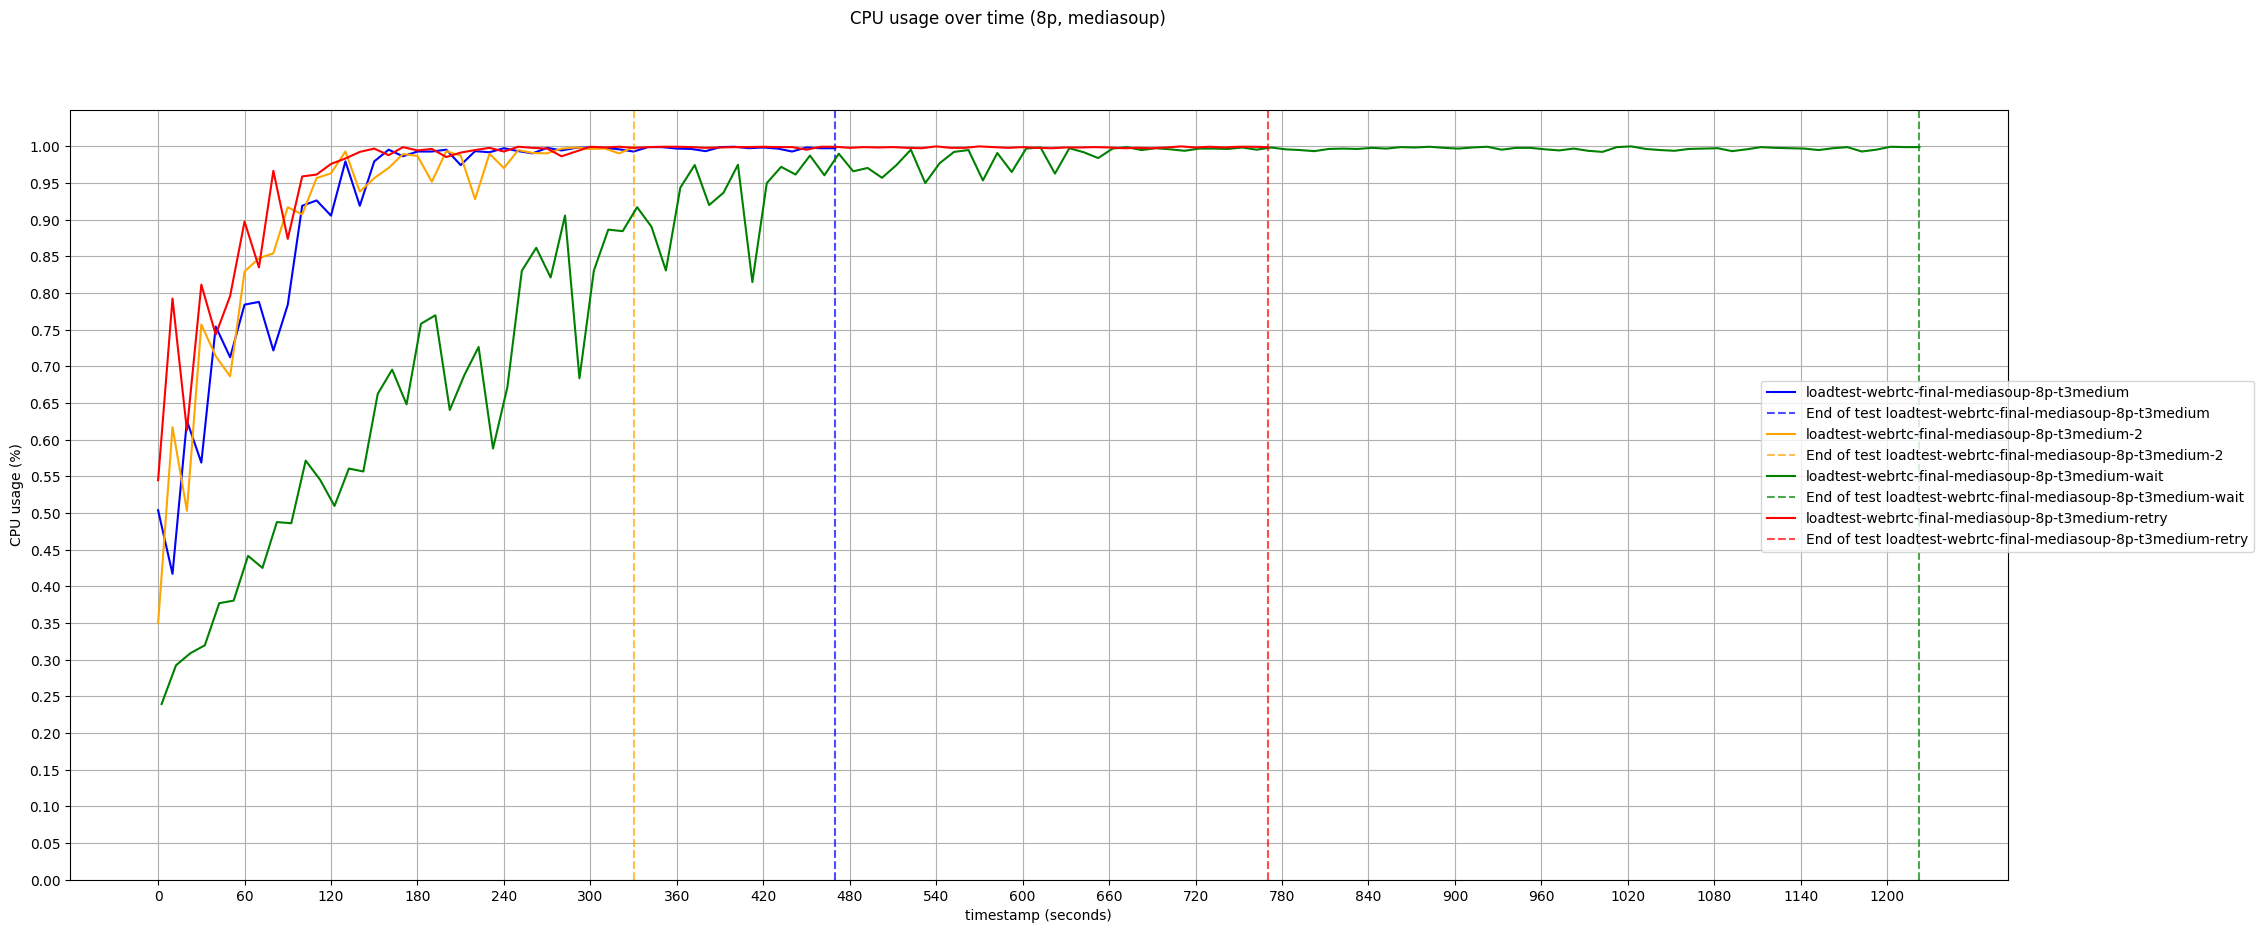

In [8]:
plt.rcParams['figure.figsize'] = [25, 10]
typologies = ["5p", "8p"]
media_nodes = ["kurento", "mediasoup"]
lines_styles = ["-", "--", "-.", ":"]
colors = ["blue", "orange", "green", "red"]
for typology in typologies:
    for media_node in media_nodes:
        fig, ax = plt.subplots()
        target_names = filter(lambda x: typology in x and media_node in x, index_list_names)

        max_x = -1
        for i, target_name in enumerate(target_names):
            df_node = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            # remove entries with cpu < 0.001
            #df_node = df_node[df_node["cpu"] > 0.001]
            df_node = timestamp_to_secs(df_node, target_name)
            df_node = df_node.drop(columns=["@timestamp", "memory"]).dropna()
            ax.plot(df_node["timestamp_secs"], df_node["cpu"], color=colors[i], label=target_name)
            plt.axvline(x=df_node["timestamp_secs"].max(), color=colors[i], linestyle='--', alpha=0.7, label="End of test " + target_name)
            max_x = np.max(np.array([max_x, df_node["timestamp_secs"].max()]))

        ax.set_xlabel("timestamp (seconds)")
        ax.set_ylabel("CPU usage (%)")
        ax.grid()
        ax.set_ylim(0, 1.05)
        ax.set_yticks(np.arange(0, 1.05, 0.05))
        ax.set_xticks(np.arange(0, max_x, 60))

        fig.suptitle(f"CPU usage over time ({typology}, {media_node})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_cpu.png")


KeyboardInterrupt: 

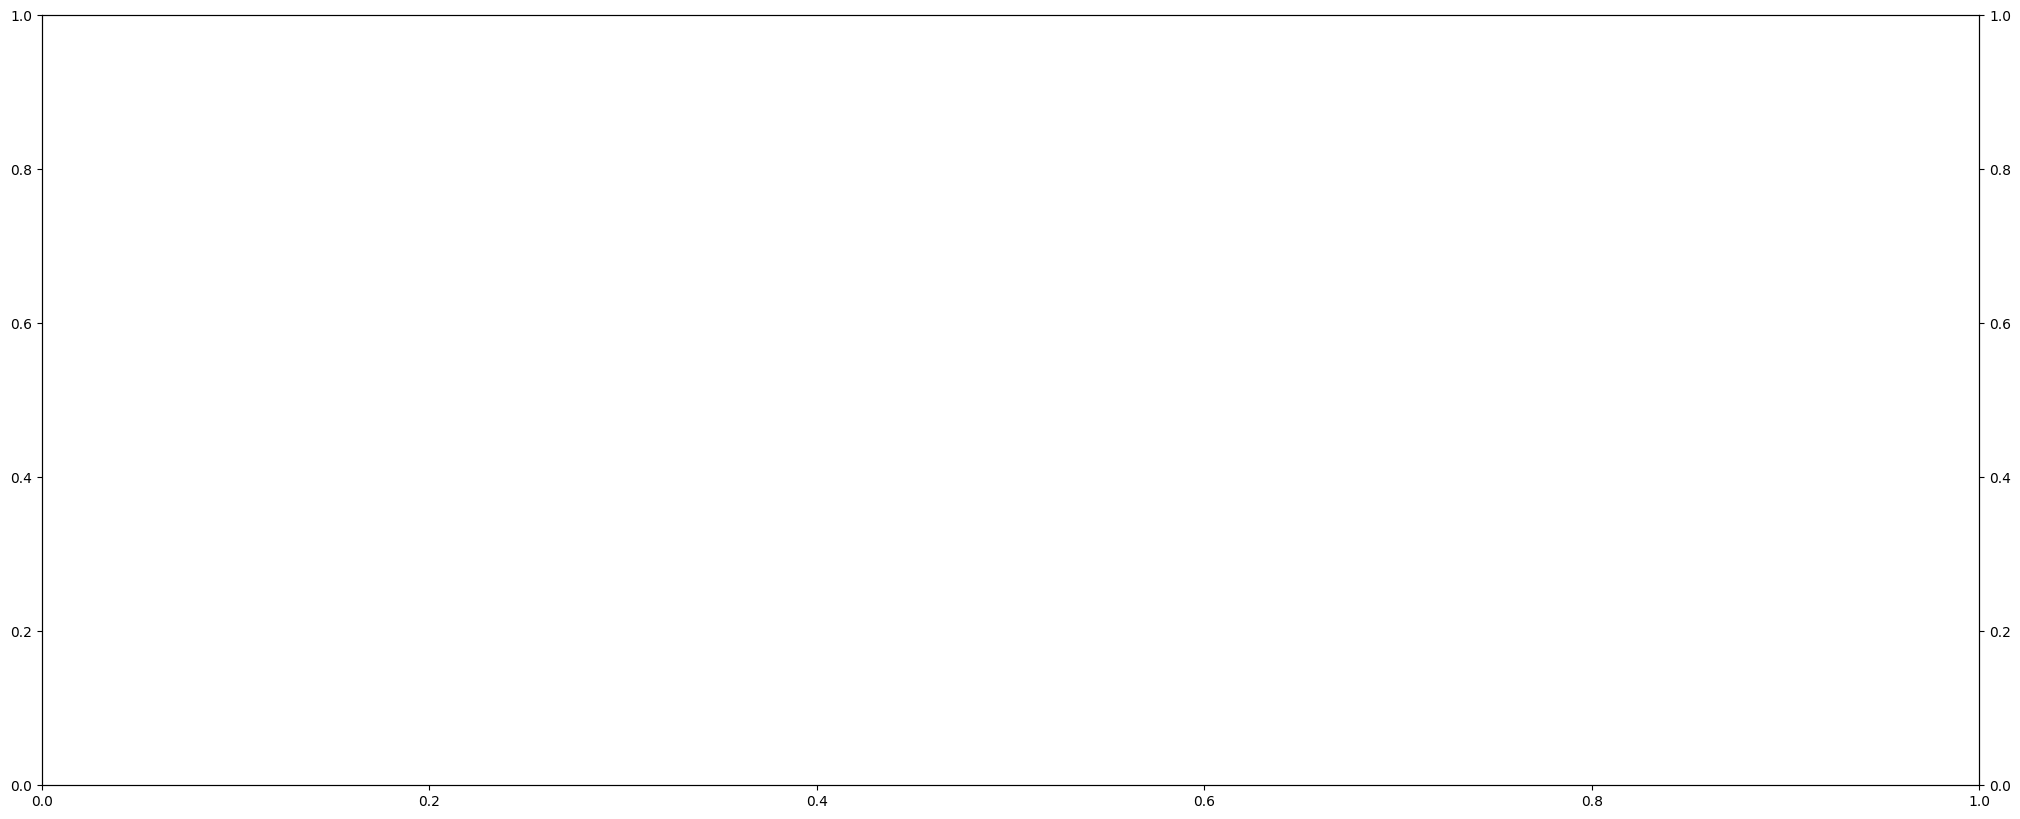

In [10]:
plt.rcParams['figure.figsize'] = [25, 10]
fig, ax = plt.subplots()

webrtc_stats_y = ax.twinx()

aggregation_map =  {"@timestamp": "first"}
for metric in qoe_metrics_normalized:
    aggregation_map[metric] = "mean"

df_tmp = df_list[index].groupby("cut_index").agg(aggregation_map)
df_tmp = timestamp_to_secs(df_tmp, index_name)
df_node = pd.read_csv(f"dfs_final/{index_name}-medianode.csv")
df_node = timestamp_to_secs(df_node, index_name)
df = df_tmp

df_node_cpu = df_node.drop(columns=["memory"]).dropna()
df_node_memory = df_node.drop(columns=["cpu"]).dropna()

df_stats_inbound = pd.read_csv(f"dfs_final/{index_name}-webrtc-stats-inbound.csv")
df_stats_outbound = pd.read_csv(f"dfs_final/{index_name}-webrtc-stats-outbound.csv")
df_stats_inbound["@timestamp"] = pd.to_datetime(df_stats_inbound["@timestamp"], format="ISO8601")
df_stats_outbound["@timestamp"] = pd.to_datetime(df_stats_outbound["@timestamp"], format="ISO8601")
df_stats_inbound = df_stats_inbound.drop(columns="user_id")
df_stats_outbound = df_stats_outbound.drop(columns="user_id")
df_stats_inbound = df_stats_inbound.groupby("@timestamp").mean()
df_stats_outbound = df_stats_outbound.groupby("@timestamp").mean()

df_stats_inbound = timestamp_to_secs(df_stats_inbound, index_name)
df_stats_outbound = timestamp_to_secs(df_stats_outbound, index_name)

qoe_zorder = 10
resource_zorder = 0

qoe_linewidth = 3
resource_linewidth = 1

legend_handles = []
for metric in qoe_metrics_normalized:
    legend_handles.append(ax.plot(df["@timestamp"], df[metric], label=metric,
             marker="o", zorder=qoe_zorder, lw=qoe_linewidth))
legend_handles.append(ax.plot(df_node_cpu["@timestamp"], df_node_cpu["cpu"], "g",
         label="cpu", zorder=resource_zorder, lw=resource_linewidth, linestyle="--"))
legend_handles.append(ax.plot(df_node_memory["@timestamp"], df_node_memory["memory"], "c",
         label="memory", zorder=resource_zorder, lw=resource_linewidth, linestyle="--"))


for column in df_stats_inbound.columns[1:]:
    # Maybe readd gpSum?
    if not "bytesSent" in column and not "packetsSent" in column and not "qpSum" in column and not "framesEncoded" in column:
        legend_handles.append(webrtc_stats_y.plot(df_stats_inbound.index, df_stats_inbound[column], label=column))

ax.set_title(f"QOE metric (normalized) over time (mean, worker data, {index_name})")
ax.set_xlabel("timestamp (day hour:minute)")
ax.set_ylabel("QOE metric (normalized), CPU %, Memory %")
webrtc_stats_y.set_ylabel("WebRTC stats")
ax.grid()
ax.legend(loc="upper left")
webrtc_stats_y.legend(loc="center left")